<a href="https://colab.research.google.com/github/nnyt00574/XAI_on_depression_systems/blob/main/XAI_on_depression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Installing Dependencies**

In [ ]:
!pip install optuna xgboost catboost lightgbm category_encoders imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 23.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
from category_encoders import TargetEncoder

import optuna
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')


In [ ]:
!pip install shap

# **Data Preprocessing**

 ##### **Dropping id and Name , Check datatypes for categorical data**

In [ ]:
import pandas as pd


train = pd.read_csv("/content/drive/MyDrive/train.csv")
test = pd.read_csv("/content/drive/MyDrive/test.csv")

train.columns = [col.replace(" ", "_") for col in train.columns]
test.columns = [col.replace(" ", "_") for col in test.columns]


train.drop(columns=["id", "Name"], inplace=True, errors="ignore")
test.drop(columns=["id", "Name"], inplace=True, errors="ignore")


num_cols = train.select_dtypes(include=["float64", "int64"]).columns.tolist()
num_cols = [col for col in num_cols if col in test.columns]

train[num_cols] = train[num_cols].fillna(train[num_cols].median())
test[num_cols] = test[num_cols].fillna(test[num_cols].median())


cat_cols = train.select_dtypes(include=["object"]).columns.tolist()
cat_cols = [col for col in cat_cols if col in test.columns]


train[cat_cols] = train[cat_cols].fillna(train[cat_cols].mode().iloc[0])
test[cat_cols] = test[cat_cols].fillna(test[cat_cols].mode().iloc[0])


print(train.info())
print(test.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 18 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Gender                                 140700 non-null  object 
 1   Age                                    140700 non-null  float64
 2   City                                   140700 non-null  object 
 3   Working_Professional_or_Student        140700 non-null  object 
 4   Profession                             140700 non-null  object 
 5   Academic_Pressure                      140700 non-null  float64
 6   Work_Pressure                          140700 non-null  float64
 7   CGPA                                   140700 non-null  float64
 8   Study_Satisfaction                     140700 non-null  float64
 9   Job_Satisfaction                       140700 non-null  float64
 10  Sleep_Duration                         140700 non-null  

 ##### **Encoding Categorical Data**

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_enc_cols = ["Gender", "Family_History_of_Mental_Illness", "Have_you_ever_had_suicidal_thoughts_?"]
for col in label_enc_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])


cat_cols = train.select_dtypes(include=["object"]).columns
train = pd.get_dummies(train, columns=cat_cols, drop_first=True)
test = pd.get_dummies(test, columns=cat_cols, drop_first=True)


test = test.reindex(columns=train.columns.drop("Depression"), fill_value=0)


  ##### **Train-test split**

In [ ]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=["Depression"])
y = train["Depression"]


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# **Model Training**

##### **CatBoost Classifier**

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

cat_model = CatBoostClassifier(verbose=0,iterations=500,random_state=42)

cat_model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True, early_stopping_rounds=50)

y_pred_cat = cat_model.predict(X_val)
y_proba_cat = cat_model.predict_proba(X_val)[:, 1]

print("CatBoost → Accuracy:", accuracy_score(y_val, y_pred_cat))
print("CatBoost → ROC-AUC:", roc_auc_score(y_val, y_proba_cat))


CatBoost → Accuracy: 0.9390547263681592
CatBoost → ROC-AUC: 0.976819636902704


##### **Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=500,random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_val)
y_proba_rf = rf_model.predict_proba(X_val)[:, 1]

print("Random Forest → Accuracy:", accuracy_score(y_val, y_pred_rf))
print("Random Forest → ROC-AUC:", roc_auc_score(y_val, y_proba_rf))


Random Forest → Accuracy: 0.9352523098791755
Random Forest → ROC-AUC: 0.9738855948860706


##### **Logistical Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=5000,random_state=42)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_val)
y_proba_lr = lr_model.predict_proba(X_val)[:, 1]

print("Logistic Regression → Accuracy:", accuracy_score(y_val, y_pred_lr))
print("Logistic Regression → ROC-AUC:", roc_auc_score(y_val, y_proba_lr))


Logistic Regression → Accuracy: 0.9369936034115138
Logistic Regression → ROC-AUC: 0.975542662147846


##### **XGBoost Classifier**

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='logloss',use_label_encoder=False,n_iterations=500,random_state=42)

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

y_pred_xgb = xgb_model.predict(X_val)
y_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]

print("XGBoost → Accuracy:", accuracy_score(y_val, y_pred_xgb))
print("XGBoost → ROC-AUC:", roc_auc_score(y_val, y_proba_xgb))


XGBoost → Accuracy: 0.9372423596304194
XGBoost → ROC-AUC: 0.9750675707819789


# **Model Comparison**

##### **Evaluation Metrics and Confusion Matrix**

                 Model  Accuracy   ROC-AUC  Precision    Recall  F1-Score
0             CatBoost  0.939055  0.976820   0.846045  0.815677  0.830584
1        Random Forest  0.935252  0.973886   0.852667  0.781529  0.815550
2  Logistic Regression  0.936994  0.975543   0.841446  0.808304  0.824542
3              XGBoost  0.937242  0.975068   0.836779  0.816647  0.826591


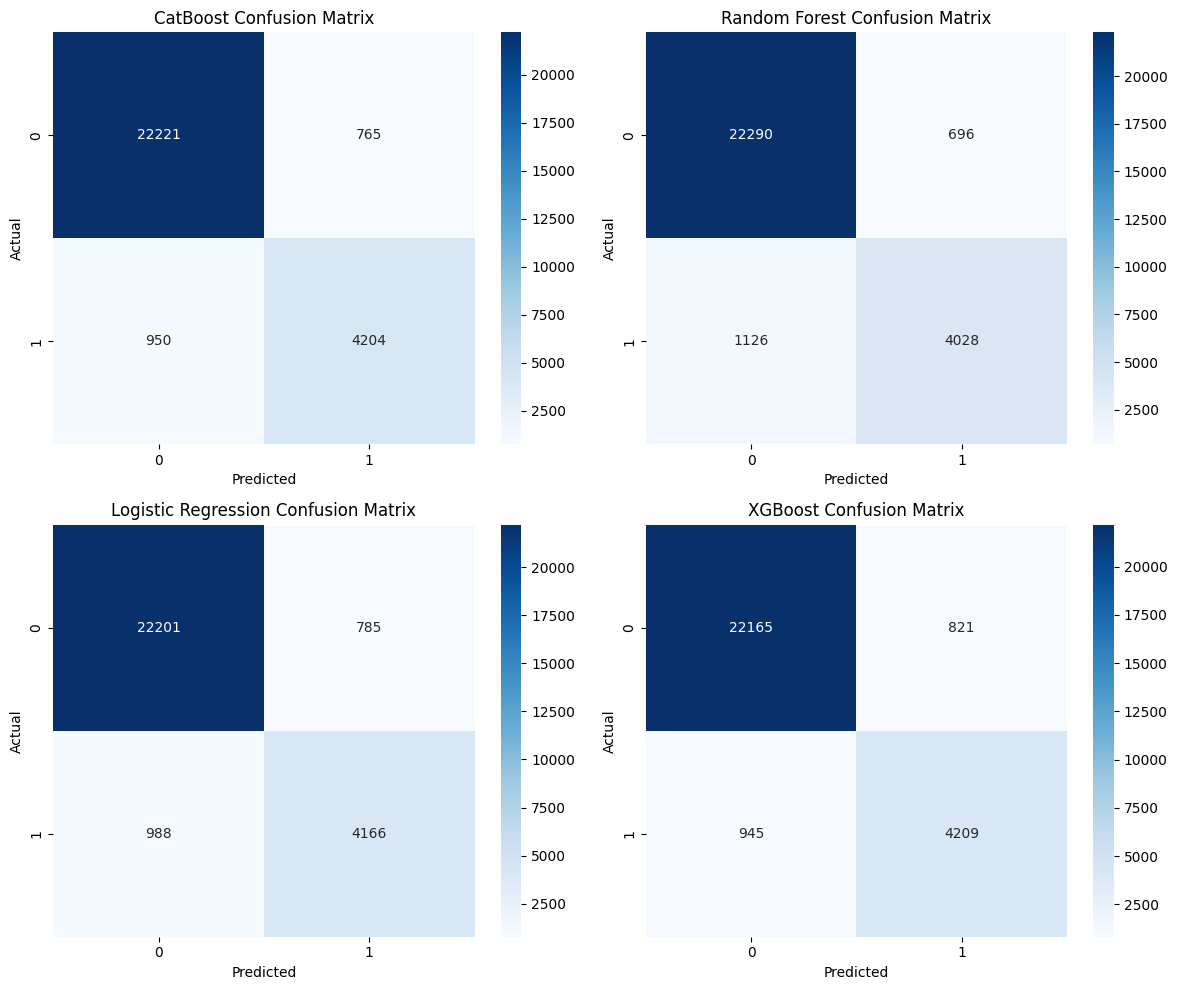

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 🔹 Helper function
# =========================
def evaluate_model(name, model, X_val, y_val):
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_proba)
    report = classification_report(y_val, y_pred, output_dict=True)
    cm = confusion_matrix(y_val, y_pred)

    return {
        "Model": name,
        "Accuracy": acc,
        "ROC-AUC": auc,
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-Score": report["1"]["f1-score"],
        "ConfusionMatrix": cm
    }

# =========================
# 🔹 Collect results
# =========================
results = []
results.append(evaluate_model("CatBoost", cat_model, X_val, y_val))
results.append(evaluate_model("Random Forest", rf_model, X_val, y_val))
results.append(evaluate_model("Logistic Regression", lr_model, X_val, y_val))
results.append(evaluate_model("XGBoost", xgb_model, X_val, y_val))

# Convert to DataFrame for comparison
df_results = pd.DataFrame(results).drop(columns="ConfusionMatrix")
print(df_results)

# =========================
# 🔹 Confusion Matrices
# =========================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, res in zip(axes.flatten(), results):
    sns.heatmap(res["ConfusionMatrix"], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{res['Model']} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


##### **ROC AUC**

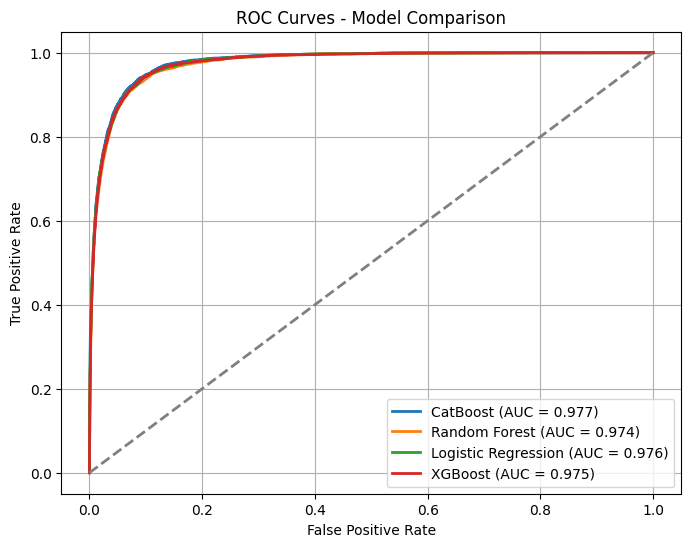

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# =========================
# 🔹 Helper function for ROC
# =========================
def plot_roc_curves(models, X_val, y_val):
    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        y_proba = model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

    # Plot diagonal line for random classifier
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)

    plt.title("ROC Curves - Model Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# =========================
# 🔹 Run ROC plotting
# =========================
models = {
    "CatBoost": cat_model,
    "Random Forest": rf_model,
    "Logistic Regression": lr_model,
    "XGBoost": xgb_model
}

plot_roc_curves(models, X_val, y_val)


# **Perform Hyperparameter Tuning on 2 best performing models**

In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "random_state": 42,
        "eval_metric": "logloss",
        "use_label_encoder": False
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred_proba)

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=30)

print("Best XGBoost params:", study_xgb.best_params)
print("Best XGBoost ROC-AUC:", study_xgb.best_value)

# Train final model
best_xgb = XGBClassifier(**study_xgb.best_params)
best_xgb.fit(X_train, y_train)
y_pred_xgb = best_xgb.predict(X_val)
y_proba_xgb = best_xgb.predict_proba(X_val)[:, 1]

print("XGBoost → Accuracy:", accuracy_score(y_val, y_pred_xgb))
print("XGBoost → ROC-AUC:", roc_auc_score(y_val, y_proba_xgb))


[I 2025-08-28 07:12:15,785] A new study created in memory with name: no-name-4b5ae88e-24c3-4b00-8fdc-1178d2d7a2ea
[I 2025-08-28 07:12:45,785] Trial 0 finished with value: 0.9738841768036768 and parameters: {'n_estimators': 175, 'max_depth': 4, 'learning_rate': 0.021699497850772166, 'subsample': 0.6883633575168664, 'colsample_bytree': 0.5745888224046769, 'gamma': 1.0263370483872531, 'reg_alpha': 7.687450485026121, 'reg_lambda': 5.932210973678088}. Best is trial 0 with value: 0.9738841768036768.
[I 2025-08-28 07:13:30,343] Trial 1 finished with value: 0.9748124383450694 and parameters: {'n_estimators': 258, 'max_depth': 6, 'learning_rate': 0.014066379463527881, 'subsample': 0.9420650839074722, 'colsample_bytree': 0.9230580801749768, 'gamma': 1.0140702649782023, 'reg_alpha': 3.727568514846485, 'reg_lambda': 3.6914767456491426}. Best is trial 1 with value: 0.9748124383450694.
[I 2025-08-28 07:15:14,231] Trial 2 finished with value: 0.9766584735268158 and parameters: {'n_estimators': 850, '

Best XGBoost params: {'n_estimators': 701, 'max_depth': 6, 'learning_rate': 0.028365554927695297, 'subsample': 0.5641263336112313, 'colsample_bytree': 0.5029968481277928, 'gamma': 2.2221885435895503, 'reg_alpha': 3.097951667335556, 'reg_lambda': 0.3371246024998731}
Best XGBoost ROC-AUC: 0.9769829020792835
XGBoost → Accuracy: 0.9381663113006397
XGBoost → ROC-AUC: 0.9769169907913443


In [ ]:
from catboost import CatBoostClassifier

def objective_cat(trial):
    params = {
        "iterations": 1000,
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_state": 42,
        "verbose": 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val),
              early_stopping_rounds=50, verbose=0)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred_proba)

study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_cat, n_trials=30)

print("Best CatBoost params:", study_cat.best_params)
print("Best CatBoost ROC-AUC:", study_cat.best_value)

# Train final model
best_cat = CatBoostClassifier(**study_cat.best_params)
best_cat.fit(X_train, y_train)
y_pred_cat = best_cat.predict(X_val)
y_proba_cat = best_cat.predict_proba(X_val)[:, 1]

print("CatBoost → Accuracy:", accuracy_score(y_val, y_pred_cat))
print("CatBoost → ROC-AUC:", roc_auc_score(y_val, y_proba_cat))


[I 2025-08-28 07:45:27,171] A new study created in memory with name: no-name-b2c42560-c2e5-43e8-beaa-b923f629e4e9
[I 2025-08-28 07:45:38,144] Trial 0 finished with value: 0.9767847588285843 and parameters: {'depth': 4, 'learning_rate': 0.2795942030161551, 'l2_leaf_reg': 8.989024609814011, 'border_count': 57}. Best is trial 0 with value: 0.9767847588285843.
[I 2025-08-28 07:45:58,139] Trial 1 finished with value: 0.9764169268256992 and parameters: {'depth': 10, 'learning_rate': 0.10625991652614385, 'l2_leaf_reg': 9.579840145558665, 'border_count': 187}. Best is trial 0 with value: 0.9767847588285843.
[I 2025-08-28 07:46:35,854] Trial 2 finished with value: 0.9768370337349308 and parameters: {'depth': 8, 'learning_rate': 0.019164642051420242, 'l2_leaf_reg': 8.313160885642546, 'border_count': 89}. Best is trial 2 with value: 0.9768370337349308.
[I 2025-08-28 07:47:05,078] Trial 3 finished with value: 0.976609524361322 and parameters: {'depth': 5, 'learning_rate': 0.014669928651209226, 'l2

Best CatBoost params: {'depth': 5, 'learning_rate': 0.1751933472583845, 'l2_leaf_reg': 6.816067124651944, 'border_count': 150}
Best CatBoost ROC-AUC: 0.9770441412921924
0:	learn: 0.4542494	total: 31.2ms	remaining: 31.2s
1:	learn: 0.3433967	total: 89.7ms	remaining: 44.8s
2:	learn: 0.2776714	total: 157ms	remaining: 52.3s
3:	learn: 0.2436138	total: 221ms	remaining: 55.1s
4:	learn: 0.2244749	total: 285ms	remaining: 56.7s
5:	learn: 0.2116661	total: 349ms	remaining: 57.8s
6:	learn: 0.1977984	total: 417ms	remaining: 59.2s
7:	learn: 0.1935849	total: 477ms	remaining: 59.1s
8:	learn: 0.1872936	total: 537ms	remaining: 59.1s
9:	learn: 0.1805336	total: 593ms	remaining: 58.7s
10:	learn: 0.1778539	total: 649ms	remaining: 58.4s
11:	learn: 0.1746927	total: 716ms	remaining: 58.9s
12:	learn: 0.1718919	total: 779ms	remaining: 59.1s
13:	learn: 0.1701256	total: 841ms	remaining: 59.3s
14:	learn: 0.1684793	total: 913ms	remaining: 59.9s
15:	learn: 0.1659571	total: 973ms	remaining: 59.8s
16:	learn: 0.1645271	to

# **SHAP Analysis**

In [ ]:
import shap
import matplotlib.pyplot as plt

def plot_shap_summary(
    model,
    model_name,
    X_train,
    X_val,
    model_type="tree",
    sample_size=500,
    max_features=20,
    approximate=True
):
    """
    Optimized SHAP summary plot function.

    Parameters:
    - model: trained model (CatBoost, XGBoost, RF, Logistic Regression, etc.)
    - model_name: str → name for plot title
    - X_train: training features (needed for LinearExplainer)
    - X_val: validation features
    - model_type: "tree" or "linear"
    - sample_size: number of rows to sample for SHAP (default=500)
    - max_features: number of top features to display in SHAP plot
    - approximate: bool, for tree models use approximation for speed
    """

    # Subsample validation set for faster computation
    if X_val.shape[0] > sample_size:
        X_sample = X_val.sample(sample_size, random_state=42)
    else:
        X_sample = X_val

    # Select correct explainer
    if model_type == "tree":
        explainer = shap.TreeExplainer(
            model,
            feature_perturbation="tree_path_dependent",
            approximate=approximate
        )
        shap_values = explainer.shap_values(X_sample)
        # For binary classification (returns list)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]

    elif model_type == "linear":
        explainer = shap.LinearExplainer(
            model,
            X_train,
            feature_perturbation="interventional"
        )
        shap_values = explainer.shap_values(X_sample)

    else:
        raise ValueError("model_type must be 'tree' or 'linear'")

    # SHAP summary plot
    plt.title(f"{model_name} - SHAP Summary Plot (Top {max_features})")
    shap.summary_plot(shap_values, X_sample, max_display=max_features, show=False)
    plt.show()


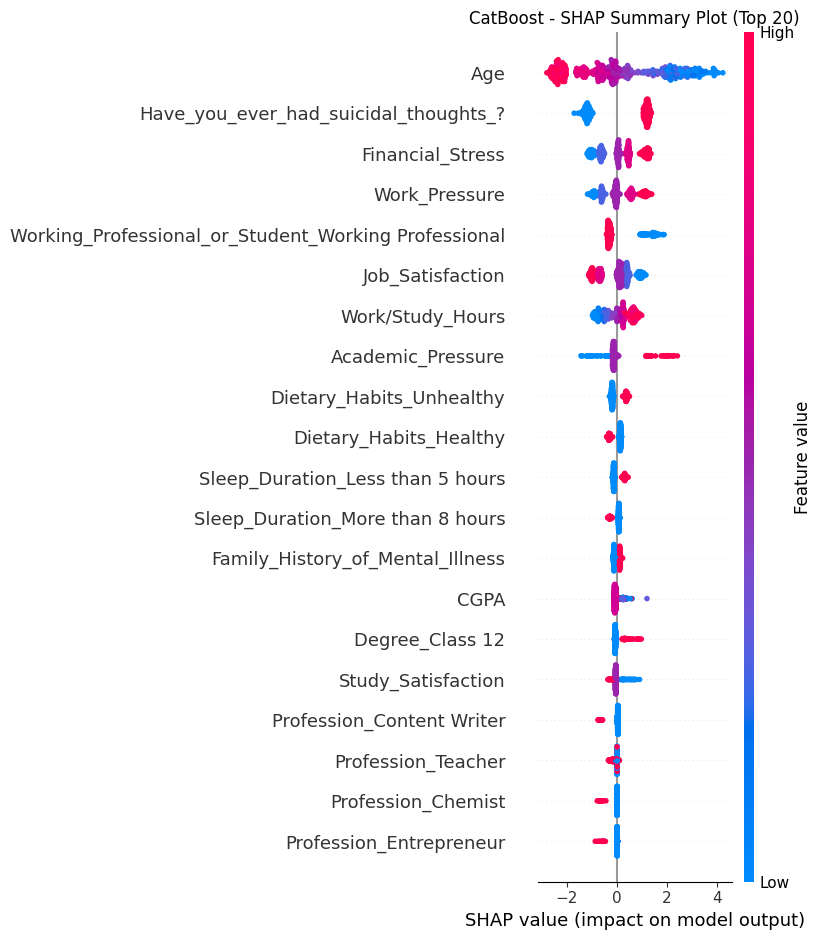

In [ ]:
# CatBoost
plot_shap_summary(best_cat, "CatBoost", X_train, X_val, model_type="tree")




In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curves(models, X_val, y_val):
    plt.figure(figsize=(8,6))
    for name, model in models.items():
        y_proba = model.predict_proba(X_val)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_proba)
        ap = average_precision_score(y_val, y_proba)
        plt.plot(recall, precision, lw=2, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curves")
    plt.legend()
    plt.show()


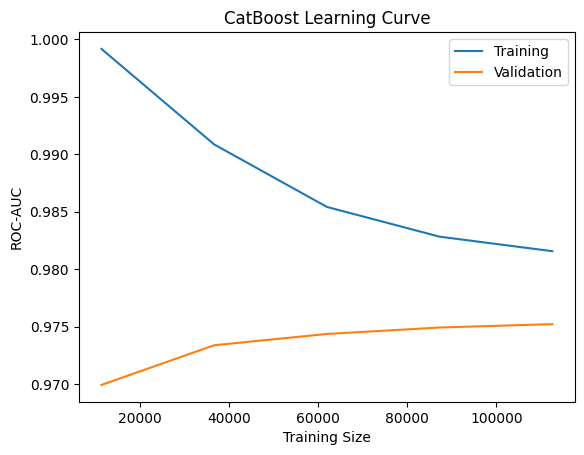

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_cat, X, y, cv=5, scoring="roc_auc", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)
plt.plot(train_sizes, train_scores.mean(axis=1), label="Training")
plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation")
plt.title("CatBoost Learning Curve")
plt.xlabel("Training Size")
plt.ylabel("ROC-AUC")
plt.legend()
plt.show()


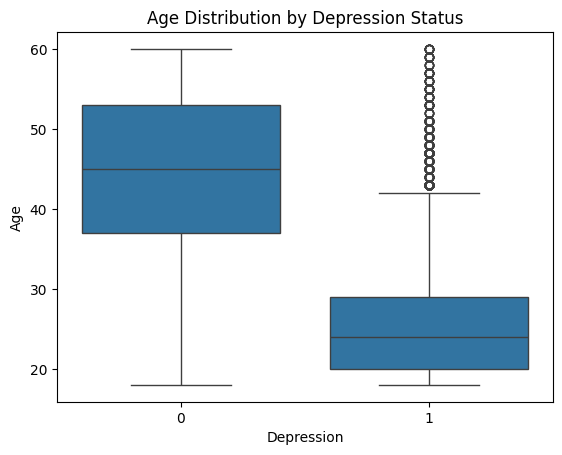

In [ ]:
sns.boxplot(x=y, y=train["Age"])
plt.title("Age Distribution by Depression Status")
plt.show()


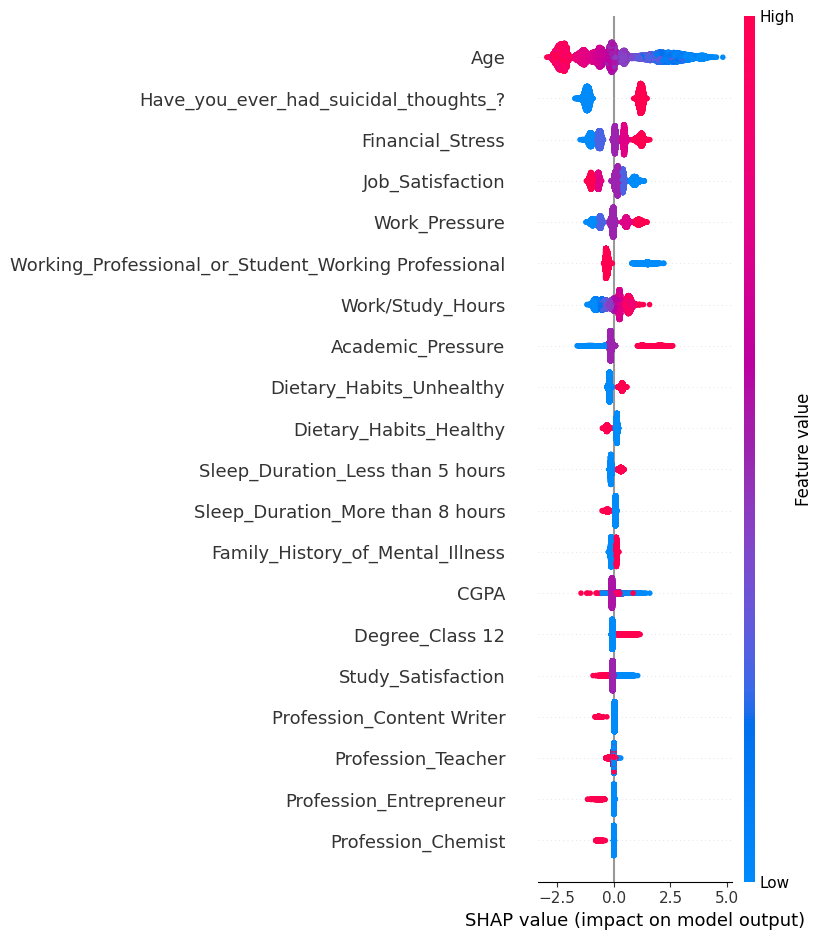

In [ ]:
import shap

# Create explainer for CatBoost (works for XGB, RF too)
explainer = shap.TreeExplainer(best_cat)
shap_values = explainer.shap_values(X_val)

# Beeswarm summary plot
shap.summary_plot(shap_values, X_val, plot_type="dot")


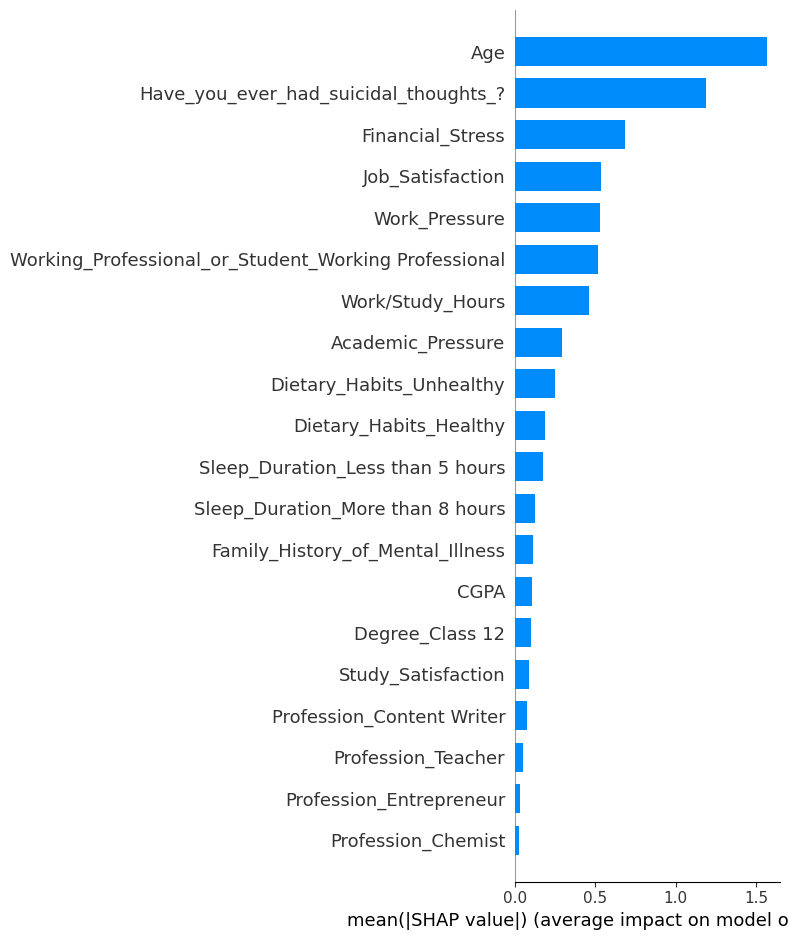

In [ ]:
shap.summary_plot(shap_values, X_val, plot_type="bar")


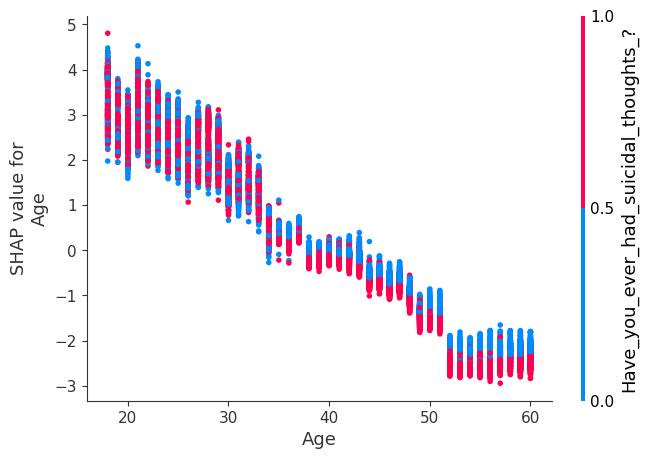

In [ ]:
shap.dependence_plot("Age", shap_values, X_val)


In [ ]:
# Pick one instance (e.g., first row of validation set)
import shap
shap.initjs()

i = 0
shap.force_plot(explainer.expected_value, shap_values[i], X_val.iloc[i])


In [ ]:
import shap
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[:10], X_val.iloc[:10])


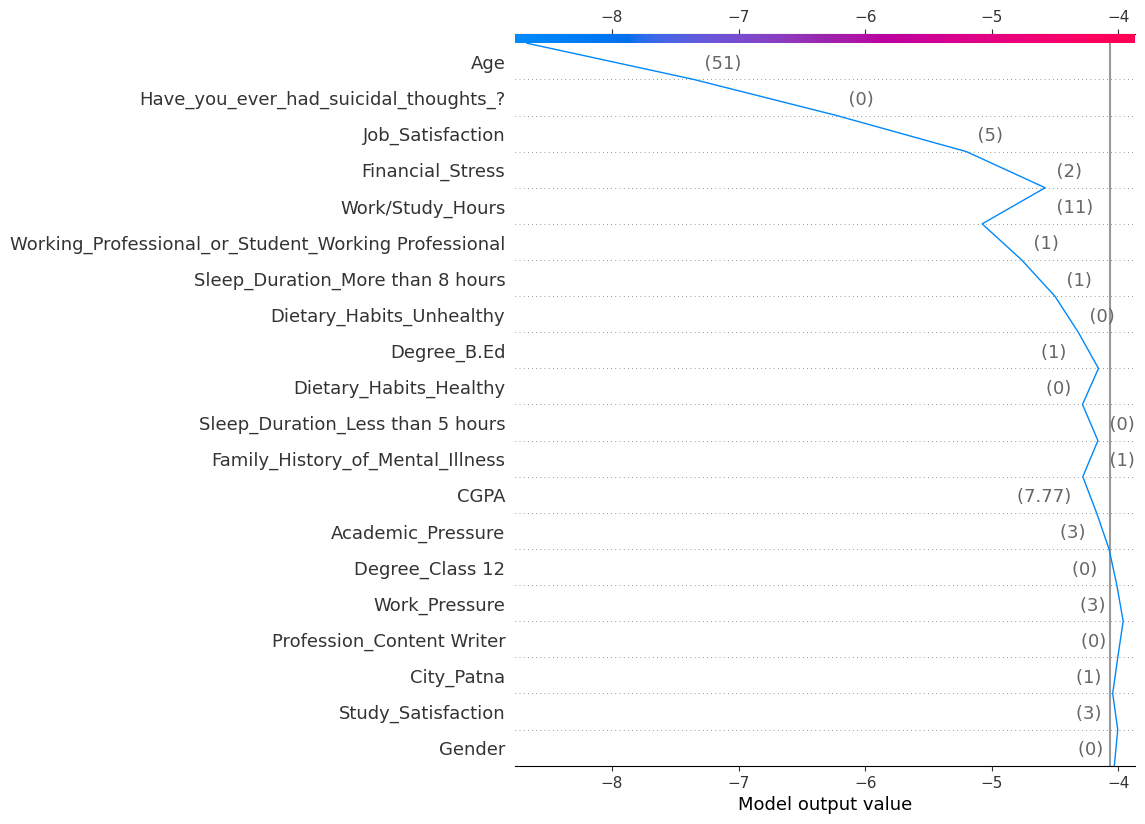

In [ ]:
import shap
shap.initjs()

i = 0
shap.decision_plot(explainer.expected_value, shap_values[i], X_val.iloc[i])


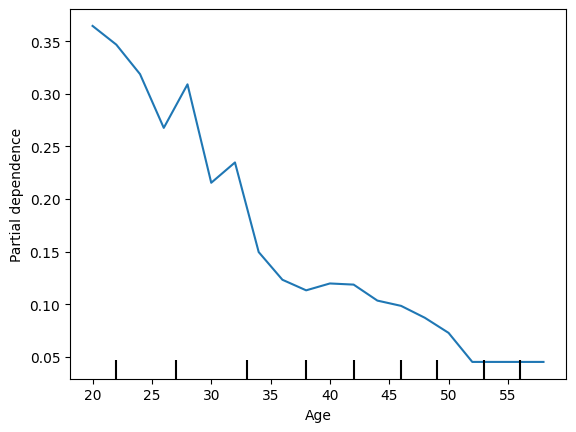

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

PartialDependenceDisplay.from_estimator(
    best_cat,
    X_val,
    features=["Age"],
    grid_resolution=20
)
plt.show()


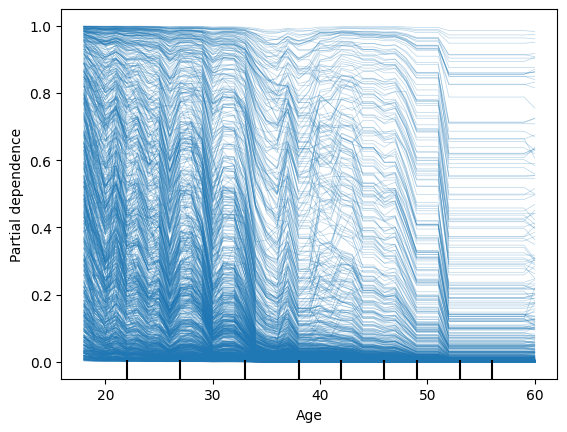

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(best_cat, X_val, features=["Age"], kind="individual")
plt.show()


In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=95d300c532b8526bc05a435478eb4ae2e85c8f86e0ccf14e40ce31e659897c6c
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

# Define explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=["No Depression", "Depression"],
    mode="classification"
)

# Pick one instance
i = 0
exp = lime_explainer.explain_instance(
    X_val.iloc[i].values,
    cat_model.predict_proba,
    num_features=10
)

# Show explanation
exp.show_in_notebook(show_table=True)
